## Here we compare the model trained without functional profiles of Orbito-frontal region (yeo network 10) with full model

In [1]:
import numpy as np
import pandas as pd
import nibabel as nb
import Functional_Fusion.dataset as fdata # from functional fusion module
import cortico_cereb_connectivity.globals as gl
import cortico_cereb_connectivity.run_model as rm
import cortico_cereb_connectivity.data as cdata
import cortico_cereb_connectivity.cio as cio
import cortico_cereb_connectivity.summarize as cs
import cortico_cereb_connectivity.scripts.script_summarize_weights as cssw
import matplotlib.pyplot as plt
import seaborn as sns
import Functional_Fusion.atlas_map as am
import nitools as nt
import SUITPy as suit
import contextlib
import os

/home/UWO/ashahb7/Documents/cortico/lib/python3.8/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
/home/UWO/ashahb7/Documents/cortico/lib/python3.8/site-packages/torch/__init__.py:955: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)


In [3]:
traindata = 'MdWfIbDeNiSoScLa'
parcellation = 'Icosahedron1002'
method = 'NNLS'

yeo_img = nb.load(gl.conn_dir + f'/maps/yeo17_{parcellation}.plabel.nii')
yeo_data = yeo_img.get_fdata().squeeze()
label_dict = yeo_img.header.get_axis(0).label[0]
atlas,ainf = am.get_atlas('MNISymC3')

colors = [label_dict[i+1][1] for i in range(17)]
names = [label_dict[i+1][0] for i in range(17)]
reg_size = [np.sum(yeo_data == i+1) for i in range(17)]

### Load full/altered model and evaluate on held-out dataset


In [6]:
conn_model, train_info = cs.get_model(traindata,parcellation,method+'_fixSTD',extension='A2_global')  
total_weights = [np.nansum(conn_model.coef_[:, yeo_data == i+1]) for i in range(17)]

model_config = rm.get_model_config()
model_config['model'] = [conn_model]
model_config['train_info'] = [train_info]

eval_config = rm.get_eval_config(eval_dataset='HCPur100', eval_ses='all', cerebellum='MNISymC3', parcellation=parcellation)

with contextlib.redirect_stdout(open(os.devnull, 'w')):
    df, df_voxel = rm.eval_model(None, None, eval_config, model_config);

In [8]:
ext_list = [f'_no-yeo{i+1}' for i in range(17)]
R_list = []
R_voxel_list = []

for ext in ext_list:
    conn_model, train_info = cs.get_model(traindata,parcellation,method+ext,extension='A2_global')  

    model_config = rm.get_model_config()
    model_config['model'] = [conn_model]
    model_config['train_info'] = [train_info]

    eval_config = rm.get_eval_config(eval_dataset='HCPur100', eval_ses='all', cerebellum='MNISymC3', parcellation=parcellation)

    with contextlib.redirect_stdout(open(os.devnull, 'w')):
        df_subset, df_voxel_subset = rm.eval_model(None, None, eval_config, model_config);

    R_list.append(np.nanmean(df_subset['R_eval'], axis=0))
    R_voxel_list.append(np.nanmean(df_voxel_subset['R_vox'], axis=0))

#### 1.1 Effect of removing a network from training (R_eval)

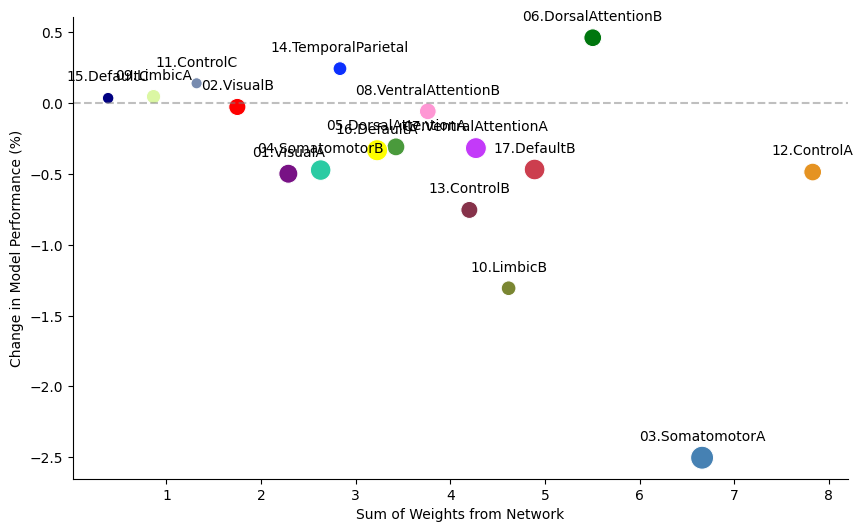

In [9]:
plt.figure(figsize=(10, 6))
ax = plt.gca()
ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
sns.scatterplot(x=total_weights, y=(R_list-df.R_eval.mean())/df.R_eval.mean()*100, s=np.array(reg_size)*1.5, color=colors, ax=ax)
for x,y,label in zip(total_weights, (R_list-df.R_eval.mean())/df.R_eval.mean()*100, names):
    ax.text(x, y+0.1, label, va='bottom', ha='center')

ax.set_xlabel('Sum of Weights from Network');
ax.set_ylabel('Change in Model Performance (%)');
sns.despine()

#### 1.2 Where in the cerebellum suffers?

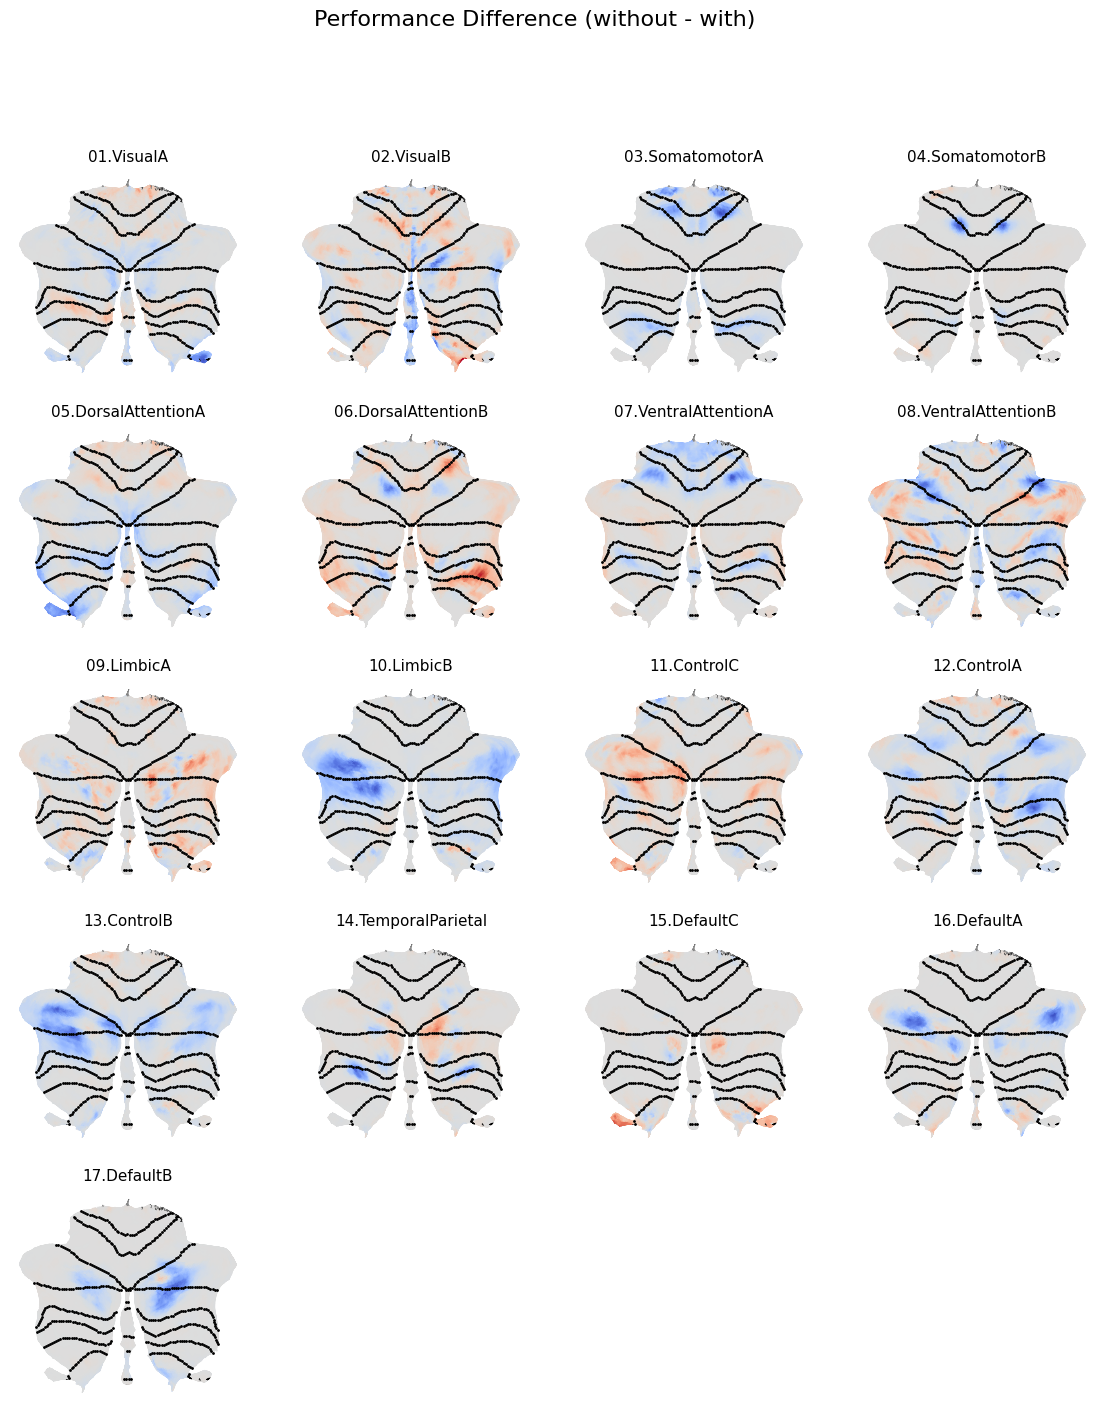

In [10]:
fig, axes = plt.subplots(5, 4, figsize=(14, 16))
# max_diff = np.nanmax([np.nanmax(np.abs(R_voxel_list[i] - np.nanmean(df_voxel['R_vox'], axis=0))) for i in range(17)]) * 0.65
for i in range(17):
    plt.subplot(5, 4, i+1)
    R_vox_diff = R_voxel_list[i] - np.nanmean(df_voxel['R_vox'], axis=0)
    nifti_image = atlas.data_to_nifti(R_vox_diff)
    data = suit.vol_to_surf(nifti_image,space='MNISymC')
    max_diff = np.nanmax(np.abs(data))
    suit.flatmap.plot(data, cmap='coolwarm', cscale=[-max_diff, max_diff], new_figure=False)
    axes.flat[i].set_title(names[i], fontsize=11)

for j in range(17, len(axes.flat)):
    axes.flat[j].axis('off')
plt.suptitle(f'Performance Difference (without - with)', fontsize=16);

### Difference plot of evaluation on R_vox (Full vs No Yeo10)

Difference in overall R: -0.002, about -1.307%


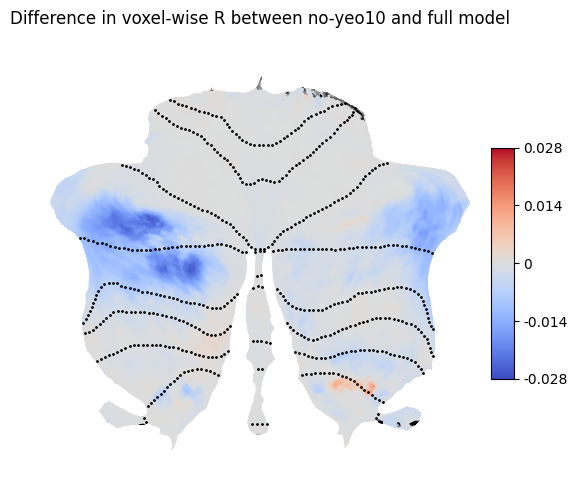

In [17]:
R_vox_diff = R_voxel_list[9] - np.nanmean(df_voxel['R_vox'], axis=0)
nifti_image = atlas.data_to_nifti(R_vox_diff)
data = suit.vol_to_surf(nifti_image,space='MNISymC')
max_diff = np.nanmax(np.abs(data))
fig, ax = plt.subplots(figsize=(7, 6))
suit.flatmap.plot(data, cmap='coolwarm', cscale=[-max_diff, max_diff], new_figure=False, colorbar=True)
ax.set_title('Difference in voxel-wise R between no-yeo10 and full model', fontsize=12);
print(f'Difference in overall R: {R_list[9] - np.nanmean(df["R_eval"], axis=0):.3f}, about {(R_list[9] - np.nanmean(df["R_eval"], axis=0)) / (np.nanmean(df["R_eval"], axis=0))*100 :.3f}%')